## W-GAN
- replace binary_crossentropy loss by wassserstein loss 
- clip kernel of discriminator by ClipConstraint

In [0]:
import os
import shutil
from sklearn.utils import shuffle
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt

In [2]:

import tensorflow as tf
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras import backend as K
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import ResNet50, VGG19, InceptionResNetV2, InceptionV3, DenseNet201
from keras.applications.xception import Xception
from keras.callbacks import *
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import re
from keras.datasets import mnist

from IPython import display

Using TensorFlow backend.


### UTILs

In [0]:
def wassersteinLoss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [0]:
from keras.constraints import Constraint
class ClipConstraint(Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return K.clip(weights, -self.clip_value, self.clip_value)
    def get_config(self):
        return {'clip_value': self.clip_value}

In [0]:
def sample_images(folder, generator, z, ep, image_grid_rows=4, image_grid_columns=4):
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    if not os.path.exists(folder):
        os.mkdir(folder)

    img_name = 'image_at_epoch_{}.png'.format(ep+1)
#   plt.savefig(img_name)
#   shutil.move(img_name, os.path.join(os.getcwd(), folder))
    plt.show()

### build Generator and Discriminator

In [0]:
from keras.layers.advanced_activations import LeakyReLU
def build_dcgan_generator(img_shape, z_dim, ker=3, useRelu=False):
    model = Sequential()
    model.add(Dense(7*7*256, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    # 7x7x256 -> 14x14x128
    model.add(Conv2DTranspose(128, kernel_size=ker, strides=2, padding='same'))
    model.add(BatchNormalization())
    if useRelu:
        model.add(ReLU())
    else:
        model.add(LeakyReLU(alpha=0.01))
  
    # 14x14x128 -> 14x14x64
    model.add(Conv2DTranspose(64, kernel_size=ker, strides=1, padding='same'))
    model.add(BatchNormalization())
    if useRelu:
        model.add(ReLU())
    else:
        model.add(LeakyReLU(alpha=0.01))
  
    # 14x14x64 -> 28x28x1
    model.add(Conv2DTranspose(1, kernel_size=ker, strides=2, padding='same'))
    model.add(Activation('tanh'))
  
    return model

In [0]:
from keras.optimizers import RMSprop
def build_dcgan_discriminator(img_shape, ker=3):
    model = Sequential()
    const = ClipConstraint(0.01)
    # 28x28x1 -> 14x14x32
    model.add(Conv2D(32, kernel_size=ker, strides=2, padding='same', kernel_constraint=const, input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x32 -> 7x7x64
    model.add(Conv2D(64, kernel_size=ker, strides=2, padding='same', kernel_constraint=const))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # 7x7x64 -> 3x3x128
    model.add(Conv2D(128, kernel_size=ker, strides=2, padding='same', kernel_constraint=const))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='linear')) # or model.add(Dense(1))
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wassersteinLoss, optimizer=opt)
    return model

### Build GAN

In [0]:
def build_wgan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wassersteinLoss, optimizer=opt)
    return model

In [0]:
def train_wgan(model_name, generator, discriminator, interations, batch_size, sample_interval):
#     random_z_for_generator = np.random.normal(0, 1, (batch_size, 100))
    losses = []
    accuracies = []
    iteration_checkpoints = []
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1
    X_train = np.expand_dims(X_train, axis=3)
    real = - np.ones((batch_size, 1))
    fake =  np.ones((batch_size, 1))

    wgan = build_wgan(generator, discriminator)
    
    for iteration in range(interations):
        # train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = np.mean([d_loss_real, d_loss_fake])
#         d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train generator
        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = wgan.train_on_batch(z, real)

        if(iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
#             accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)

#             print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
#                       (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            #       display.clear_output(wait=True)
            sample_images(model_name, generator, random_z_for_generator,iteration)

### TEST

In [0]:
random_z_for_generator = np.random.normal(0, 1, (4 * 4, 100))

In [0]:
z_dim, img_shape = 100, (28,28,1)
iterations = 100000
batch_size = 128
sample_interval = 10000

In [0]:
generator = build_dcgan_generator(img_shape, z_dim, ker=5, useRelu=True)
discriminator = build_dcgan_discriminator(img_shape, ker=5)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


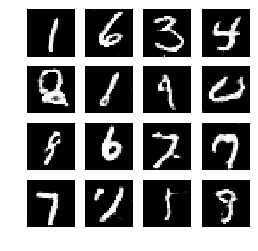

In [0]:
train_wgan('wgan', generator, discriminator, iterations, batch_size, sample_interval)